In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [7]:
data = pd.read_csv("/home/cp/DataSet/GMB(Groningen Meaning Bank) corpus/ner_dataset.csv",encoding="latin1")
data = data.fillna(method='ffill')

In [8]:
data.tail()

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [9]:
data['Word'].values

array(['Thousands', 'of', 'demonstrators', ..., 'to', 'the', 'attack'],
      dtype=object)

In [10]:
word = list(set(data['Word']))#唯一单词
word.append('ENDPAD')
n_word = len(word)
print("n_word: ",n_word)
tag = list(set(data['Tag']))
n_tag = len(tag)
print("n_tag", n_tag)

print(tag)

n_word:  35179
n_tag 17
['B-tim', 'I-per', 'O', 'B-geo', 'B-gpe', 'I-art', 'B-art', 'I-org', 'B-per', 'I-gpe', 'I-tim', 'I-nat', 'B-org', 'B-eve', 'I-eve', 'B-nat', 'I-geo']


In [11]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [13]:
sentences = getter.sentences
print(sentences[:2])

[[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')], [('Iranian', 'JJ', 'B-gpe'), ('officials', 'NNS', 'O'), ('say', 'VBP', 'O'), ('they', 'PRP', 'O'), ('expect', 'VBP', 'O'), ('to', 'TO', 'O'), ('get', 'VB', 'O'), ('access', 'NN', 'O'), ('to', 'TO', 'O'), ('sealed', 'JJ', 'O'), ('sensitive', 'JJ', 'O'), ('parts', 'NNS', 'O'), ('of', 'IN', 'O'), ('the', 'DT', 'O'), ('plant', 'NN', 'O'), ('Wednesday', 'NNP', 'B-tim'), (',', ',', 'O'), ('after', 'IN', 'O'), ('an', 'DT', 'O'), ('IAEA', 'NNP', 'B-org'

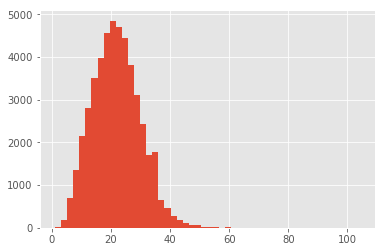

In [14]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [18]:
word2idx = {w: i for i, w in enumerate(word)}
tag2idx = {t: i for i, t in enumerate(tag)}
print(tag2idx)

{'B-tim': 0, 'I-per': 1, 'O': 2, 'B-geo': 3, 'B-gpe': 4, 'I-art': 5, 'B-art': 6, 'I-org': 7, 'B-per': 8, 'I-gpe': 9, 'I-tim': 10, 'I-nat': 11, 'B-org': 12, 'B-eve': 13, 'I-eve': 14, 'B-nat': 15, 'I-geo': 16}


In [19]:
from keras.preprocessing.sequence import pad_sequences
#获取每个句子对应的id
X = [[word2idx[w[0]] for w in s] for s in sentences]
print(X[:2])
#填充到最大长度
max_len = 50
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_word - 1)
print(np.shape(X))
y = [[tag2idx[w[2]] for w in s] for s in sentences]
#把y标签填充的时候 补充的值是其他‘0’对应的id  !!
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
print(np.shape(y))
###!!!!!
y = [to_categorical(i, num_classes=n_tag) for i in y]
print(np.shape(y))

[[22217, 9784, 21067, 21596, 5981, 17056, 18803, 21712, 26564, 26503, 23909, 28595, 13224, 31364, 9736, 26503, 12886, 9784, 19128, 30763, 9527, 22337, 31233, 29778], [24607, 22455, 20203, 7192, 29303, 21712, 25025, 11713, 21712, 18276, 31043, 24034, 9784, 26503, 28756, 35049, 4392, 7057, 15193, 10619, 1669, 33219, 11199, 17296, 29778]]
(47959, 50)
(47959, 50)
(47959, 50, 17)


We split in train and test set.

In [106]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [20]:
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=n_word, output_dim=50, input_length=max_len)(inputs)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
print(model)
out = TimeDistributed(Dense(n_tag, activation="softmax"))(model)  # softmax output layer

model = Model(inputs,out)
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

model.summary()

from keras.utils.vis_utils import plot_model
plot_model(model,to_file ="./sequence_tag_with_neural_network.png",show_shapes =True)

Tensor("bidirectional_1/concat_2:0", shape=(?, ?, 200), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_tr,
                    np.array(y_tr),
                    batch_size=32,
                    epochs=5, 
                    validation_split=0.1, 
                    verbose=1)

In [ ]:
loss = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'r',label = 'train acc')
plt.plot(epochs,val_acc,'b',label='val acc')
plt.title('train and val acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
loss = history.history['loss']
val_acc = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'r',label = 'train loss')
plt.plot(epochs,val_acc,'b',label='val loss')
plt.title('train and val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
i = 230
p = model.predict(np.array([X_te[i]]))

In [ ]:

print(np.shape(p))
print(p)

In [ ]:
p = np.argmax(p, axis=-1)
print(p)

In [ ]:
print("{:12} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(word[w], tag[pred]))